# Create a Baseline Classification

To undertake a change detection we first require a baseline classification. This notebook will undertake that classification. To create the base classification for the following change analysis (Notebooks 2 - 4). The classification will have three classes:

1. Mangroves
2. Other-Terrestrial
3. Water

The classification will be undertaken using the XGBoost classifier.


## Datasets and Study Area

For this tutorial we will focus on the Rufiji Delta in Tanzania and on observing changing in mangrove extent.

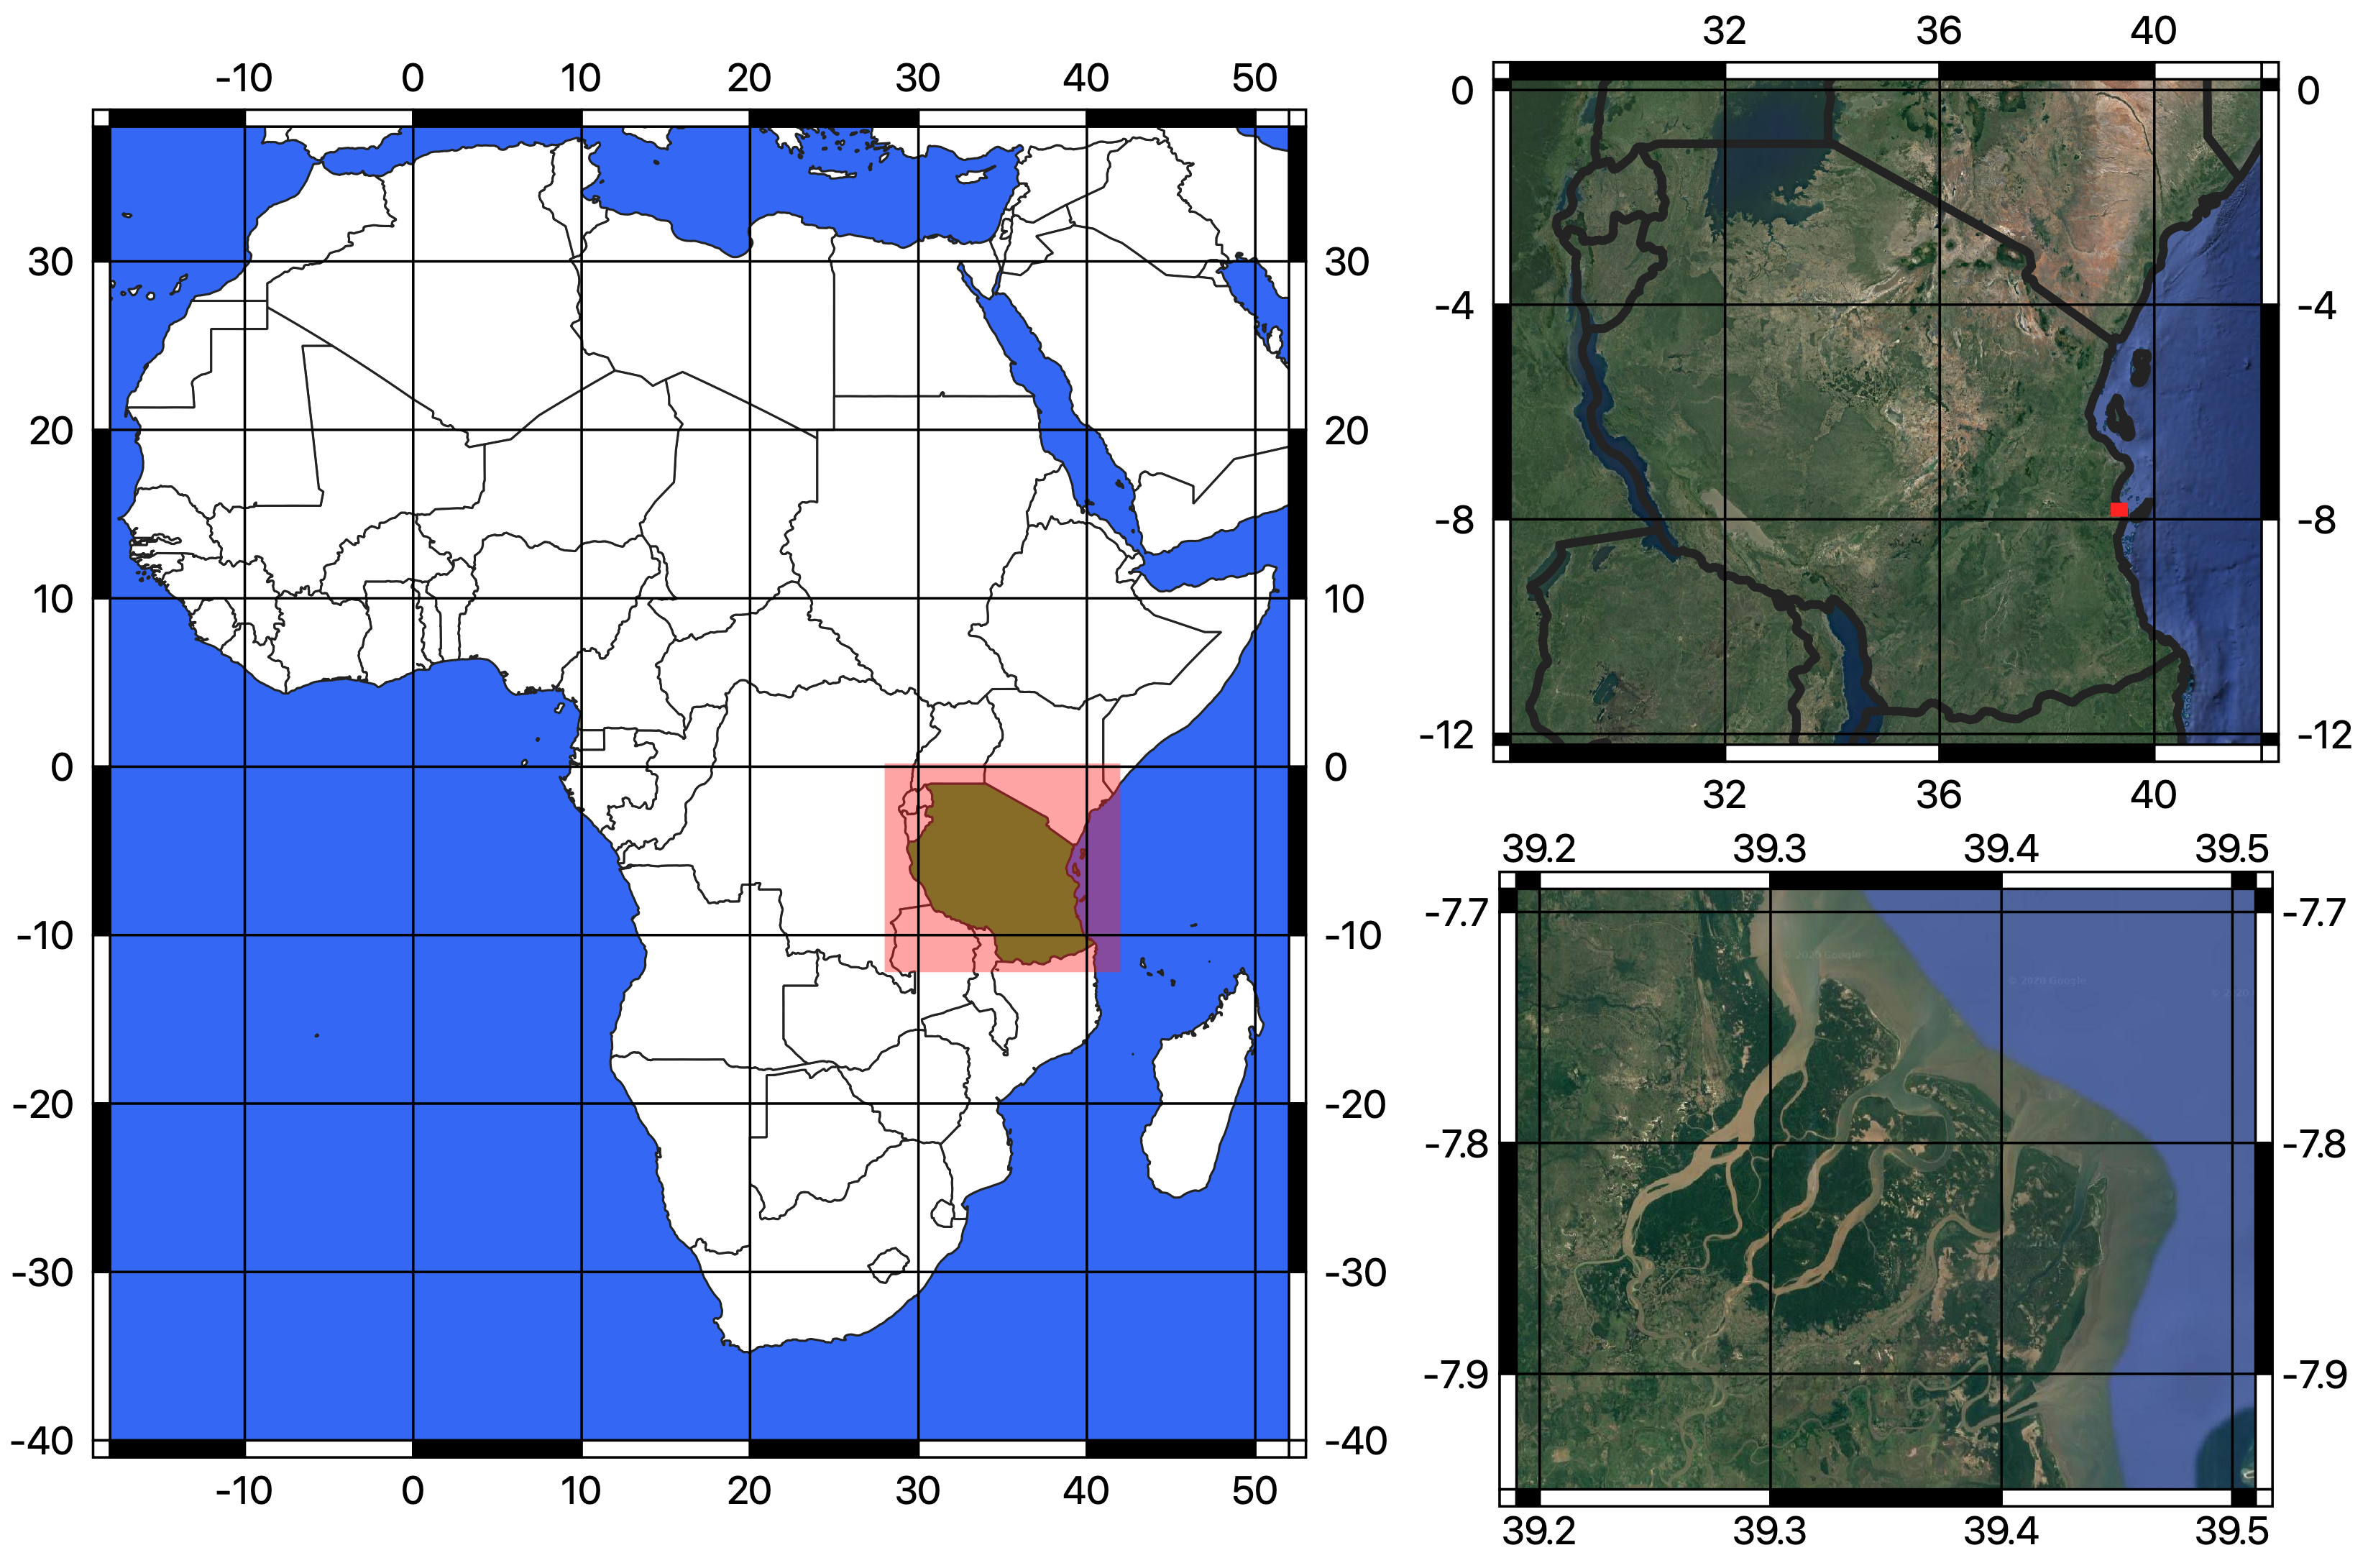


## 1. Define Imports

In [1]:
# Import the matplotlib plotting module and set it to work within
# a notebook environment.
%matplotlib inline

import os
import shutil

import matplotlib
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import rsgislib
import rsgislib.classification
import rsgislib.imagecalc
import rsgislib.imageutils
import rsgislib.rastergis
import rsgislib.tools.mapping
import rsgislib.vectorutils.createrasters
from rsgislib.classification import ClassInfoObj, ClassVecSamplesInfoObj, classxgboost
from rsgislib.imageutils import ImageBandInfo

## 2. Define Input Data and Directories

In [2]:
out_dir = "baseline_cls"
if not os.path.exists(out_dir):
    os.mkdir(out_dir)

tmp_dir = "tmp"
if not os.path.exists(tmp_dir):
    os.mkdir(tmp_dir)

# File path to the input Landsat 5 image from 1997.
input_img = (
    "../data/chg_data/LS5TM_19970716_vmsk_mclds_topshad_rad_srefdem_stdsref_subset.tif"
)

imgs_info = []
imgs_info.append(
    ImageBandInfo(file_name=input_img, name="ls97", bands=[1, 2, 3, 4, 5, 6])
)

## 3. Define Training Samples

In [3]:
class_vec_sample_info = list()

# Define the file name of the samples HDF5 file, which will be created
class_vec_sample_info.append(
    ClassVecSamplesInfoObj(
        id=1,
        class_name="mangroves",
        vec_file="../data/chg_data/training/mangroves.geojson",
        vec_lyr="mangroves",
        file_h5="baseline_cls/mangrove_cls_samples.h5",
    )
)

# Define the file name of the samples HDF5 file, which will be created
class_vec_sample_info.append(
    rsgislib.classification.ClassVecSamplesInfoObj(
        id=2,
        class_name="other_terrestrial",
        vec_file="../data/chg_data/training/other_terrestrial.geojson",
        vec_lyr="other_terrestrial",
        file_h5="baseline_cls/other_terrestrial_cls_samples.h5",
    )
)

# Define the file name of the samples HDF5 file, which will be created
class_vec_sample_info.append(
    rsgislib.classification.ClassVecSamplesInfoObj(
        id=3,
        class_name="water",
        vec_file="../data/chg_data/training/water.geojson",
        vec_lyr="water",
        file_h5="baseline_cls/water_cls_samples.h5",
    )
)

## 4. Extract Training Data

In [4]:
cls_smpls_info = rsgislib.classification.get_class_training_data(
    imgs_info, class_vec_sample_info, tmp_dir, ref_img=input_img
)

Creating output image using input image

Running Rasterise now...
Get Image Min and Max.

Get Image Histogram.

Adding Histogram and Colour Table to image file
Calculating Image Pyramids.


Creating output image using input image
Running Rasterise now...

Get Image Min and Max.

Creating output image using input image
Get Image Histogram.

Adding Histogram and Colour Table to image file
Calculating Image Pyramids.


Running Rasterise now...

Get Image Min and Max.

Get Image Histogram.

Adding Histogram and Colour Table to image file
Calculating Image Pyramids.




## 5. Define Class Colours

In [5]:
cls_smpls_info["mangroves"].red = 0
cls_smpls_info["mangroves"].green = 255
cls_smpls_info["mangroves"].blue = 0

cls_smpls_info["other_terrestrial"].red = 180
cls_smpls_info["other_terrestrial"].green = 180
cls_smpls_info["other_terrestrial"].blue = 180

cls_smpls_info["water"].red = 0
cls_smpls_info["water"].green = 0
cls_smpls_info["water"].blue = 255

## 6. Number of Samples

Check the number of samples there are per class to help define the number of training, testing and validation samples.

In [6]:
for cls_name in cls_smpls_info:
    smpls_h5_file = cls_smpls_info[cls_name].file_h5
    n_smpls = rsgislib.classification.get_num_samples(smpls_h5_file)
    print(f"{cls_name}: {n_smpls}")

mangroves: 57682
other_terrestrial: 84804
water: 242146


## 7. Define Testing, Validation and Training Samples

In [7]:
# Get a ClassInfoObj dict specifying paths for training, testing and validation
# datasets.
cls_smpls_fnl_info = rsgislib.classification.get_class_info_dict(
    cls_smpls_info, out_dir
)

# Run the create_train_valid_test_sets helper function to
# create the train, valid and test datasets
rsgislib.classification.create_train_valid_test_sets(
    cls_smpls_info,
    cls_smpls_fnl_info,
    10000,
    10000,
    35000,
    datatype=rsgislib.TYPE_16UINT,
)

0=1: (Train:baseline_cls/mangrove_cls_samples_train.h5, Test:baseline_cls/mangrove_cls_samples_test.h5, Valid:baseline_cls/mangrove_cls_samples_valid.h5), (0, 255, 0)
1=2: (Train:baseline_cls/other_terrestrial_cls_samples_train.h5, Test:baseline_cls/other_terrestrial_cls_samples_test.h5, Valid:baseline_cls/other_terrestrial_cls_samples_valid.h5), (180, 180, 180)
2=3: (Train:baseline_cls/water_cls_samples_train.h5, Test:baseline_cls/water_cls_samples_test.h5, Valid:baseline_cls/water_cls_samples_valid.h5), (0, 0, 255)


## 8. Define Classification Mask

Mangroves have a unique habitat being close to the coastline with a low elevation. It is therefore no appropriate to look to classify mangroves in other locations. In this case we will use a mangrove habitat mask similar to that used as part of the global mangrove watch study (Bunting et al., 2018). 


### 8.1 Rasterise Mangrove Habitat Mask

In [8]:
vec_file = "../data/chg_data/mangrove_habitat.geojson"
vec_lyr = "mangrove_habitat"

mng_hab_msk_img = os.path.join(out_dir, "mangrove_habitat.kea")

rsgislib.vectorutils.createrasters.rasterise_vec_lyr(
    vec_file, vec_lyr, input_img, mng_hab_msk_img, gdalformat="KEA", burn_val=1
)

Creating output image using input image
Running Rasterise now...

Get Image Min and Max.

Get Image Histogram.

Adding Histogram and Colour Table to image file
Calculating Image Pyramids.



### 8.2 Create Landsat Valid Mask

We need to check which pixels are valid within the landsat image so only those with image pixels values are being used.


In [9]:
vld_pxl_msk_img = os.path.join(out_dir, "LS5TM_19970716_vmsk.kea")

# Calculate the valid mask
rsgislib.imageutils.gen_valid_mask(
    input_img, vld_pxl_msk_img, gdalformat="KEA", no_data_val=0.0
)

# Populate with stats and pyramids - note it is a binary mask
# so a thematic datasets and therefore the rastergis function
# is used.
rsgislib.rastergis.pop_rat_img_stats(
    vld_pxl_msk_img, add_clr_tab=True, calc_pyramids=True, ignore_zero=True
)

0) ../data/chg_data/LS5TM_19970716_vmsk_mclds_topshad_rad_srefdem_stdsref_subset.tif
New image width = 1281 height = 3659 bands = 1

Get Image Min and Max.

Get Image Histogram.

Adding Histogram and Colour Table to image file
Calculating Image Pyramids.



### 8.3 Merge Habitat and Valid Pixel Masks

In [10]:
mng_scn_hab_msk_img = os.path.join(out_dir, "LS5TM_19970716_vmsk_mng_hab.kea")

# Create Mask for pixels which are valid and within the mangrove habitat mask.
band_defns = list()
band_defns.append(rsgislib.imagecalc.BandDefn("vld", vld_pxl_msk_img, 1))
band_defns.append(rsgislib.imagecalc.BandDefn("hab", mng_hab_msk_img, 1))
rsgislib.imagecalc.band_math(
    mng_scn_hab_msk_img,
    "(vld==1)&&(hab==1)?1:0",
    "KEA",
    rsgislib.TYPE_8UINT,
    band_defns,
)

# Populate the output binary mask with stats and pyramids.
rsgislib.rastergis.pop_rat_img_stats(
    mng_scn_hab_msk_img, add_clr_tab=True, calc_pyramids=True, ignore_zero=True
)

Image: baseline_cls/LS5TM_19970716_vmsk.kea
	 Variable 'vld' is band 1
Image: baseline_cls/mangrove_habitat.kea
	 Variable 'hab' is band 1
New image width = 1281 height = 3659 bands = 1

Get Image Min and Max.

Get Image Histogram.

Adding Histogram and Colour Table to image file
Calculating Image Pyramids.



### 8.4 Visualise Mask

Image Data Size: 1281 x 3659
Image Data Size: 1281 x 3659


/Users/pfb/miniconda3/envs/osgeo-env-v4-dev/lib/python3.11/site-packages/matplotlib/cm.py:494: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


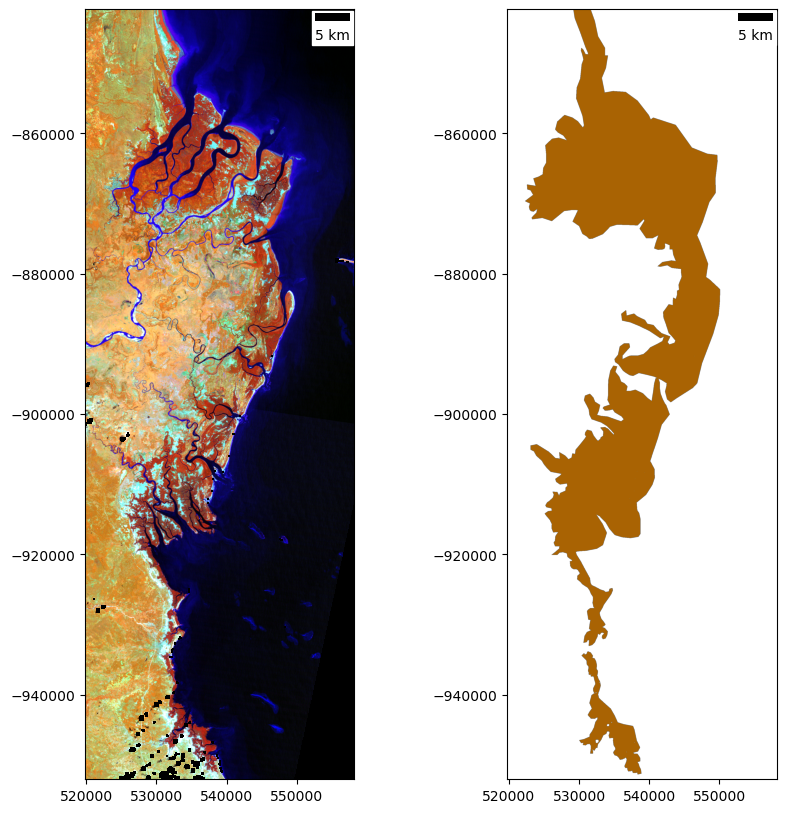

In [11]:
# Create the matplotlib figure
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10))

# Plot the input image
rsgislib.tools.mapping.create_raster_img_map(
    ax1,
    input_img,
    img_bands=[4, 5, 3],
    img_stch=rsgislib.IMG_STRECTH_CUMULATIVE,
    show_scale_bar=True,
)

# Plot the mask
rsgislib.tools.mapping.create_thematic_raster_map(ax2, mng_scn_hab_msk_img)

## 9. Train Classifier

In this example, a XGBoost classifier is used and the parameters are optimised using a bayesian optimisation.

In [13]:
# Train the classifier
out_mdl_file = os.path.join(out_dir, "cls_xgb_mdl.json")
classxgboost.train_opt_xgboost_multiclass_classifier(
    out_mdl_file,
    cls_smpls_fnl_info,
    op_mthd=rsgislib.OPT_MTHD_BAYESOPT,
    n_opt_iters=50,
    rnd_seed=None,
)

Reading Class mangroves Training
Reading Class mangroves Validation
Reading Class mangroves Testing
Reading Class other_terrestrial Training
Reading Class other_terrestrial Validation
Reading Class other_terrestrial Testing
Reading Class water Training
Reading Class water Validation
Reading Class water Testing
Finished Reading Data
Using: OPT_MTHD_BAYESOPT
|   iter    |  target   |    eta    |   gamma   | max_de... | max_depth | min_ch... | num_bo... | subsample |
-------------------------------------------------------------------------------------------------------------
| 1         | 0.9935    | 0.1625    | 4.082     | 7.688     | 6.75      | 9.348     | 88.59     | 0.912     |
| 2         | 0.9931    | 0.5472    | 6.012     | 0.4953    | 8.751     | 6.248     | 32.6      | 0.6746    |
| 3         | 0.9916    | 0.8215    | 82.31     | 3.109     | 18.46     | 6.852     | 91.56     | 0.9345    |
| 4         | 0.9918    | 0.8038    | 64.24     | 6.02      | 9.088     | 4.184     | 62.11

## 10. Apply Classifier

In [14]:
# Apply the classifier to the image
out_cls_img = os.path.join(out_dir, "base_1997_class_img.kea")
classxgboost.apply_xgboost_multiclass_classifier(
    out_mdl_file,
    cls_smpls_fnl_info,
    in_msk_img=mng_scn_hab_msk_img,
    img_msk_val=1,
    img_file_info=imgs_info,
    out_class_img=out_cls_img,
    gdalformat="KEA",
    class_clr_names=True,
    n_threads=1,
)

Applying the Classifier


  0%|          | 0/100 [00:00<?, ?it/s]

Completed Classification
Get Image Min and Max.

Get Image Histogram.

Adding Histogram and Colour Table to image file
Calculating Image Pyramids.

Apply Colour to class 'mangroves'
Apply Colour to class 'other_terrestrial'
Apply Colour to class 'water'


## 11. Visualise Classification Result

Image Data Size: 1281 x 3659
Image Data Size: 1281 x 3659


/Users/pfb/miniconda3/envs/osgeo-env-v4-dev/lib/python3.11/site-packages/matplotlib/cm.py:494: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


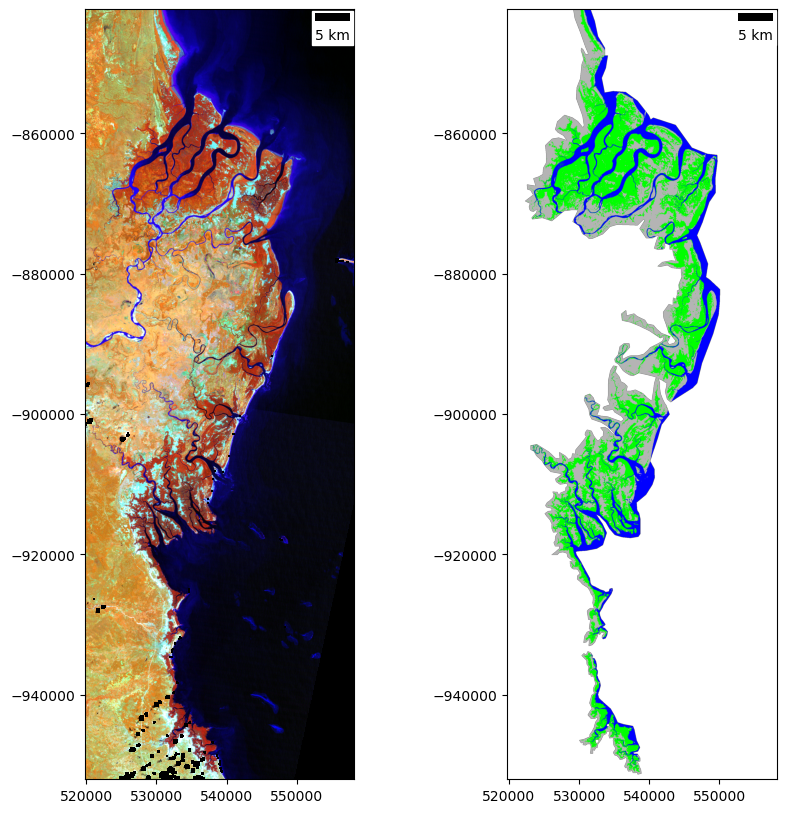

In [15]:
# Create the matplotlib figure
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10))

# Plot the input image
rsgislib.tools.mapping.create_raster_img_map(
    ax1,
    input_img,
    img_bands=[4, 5, 3],
    img_stch=rsgislib.IMG_STRECTH_CUMULATIVE,
    show_scale_bar=True,
)

# Plot the classification result
rsgislib.tools.mapping.create_thematic_raster_map(ax2, out_cls_img)

## 12. Visualise Subset

Image Data Size: 900 x 767
Image Data Size: 900 x 767


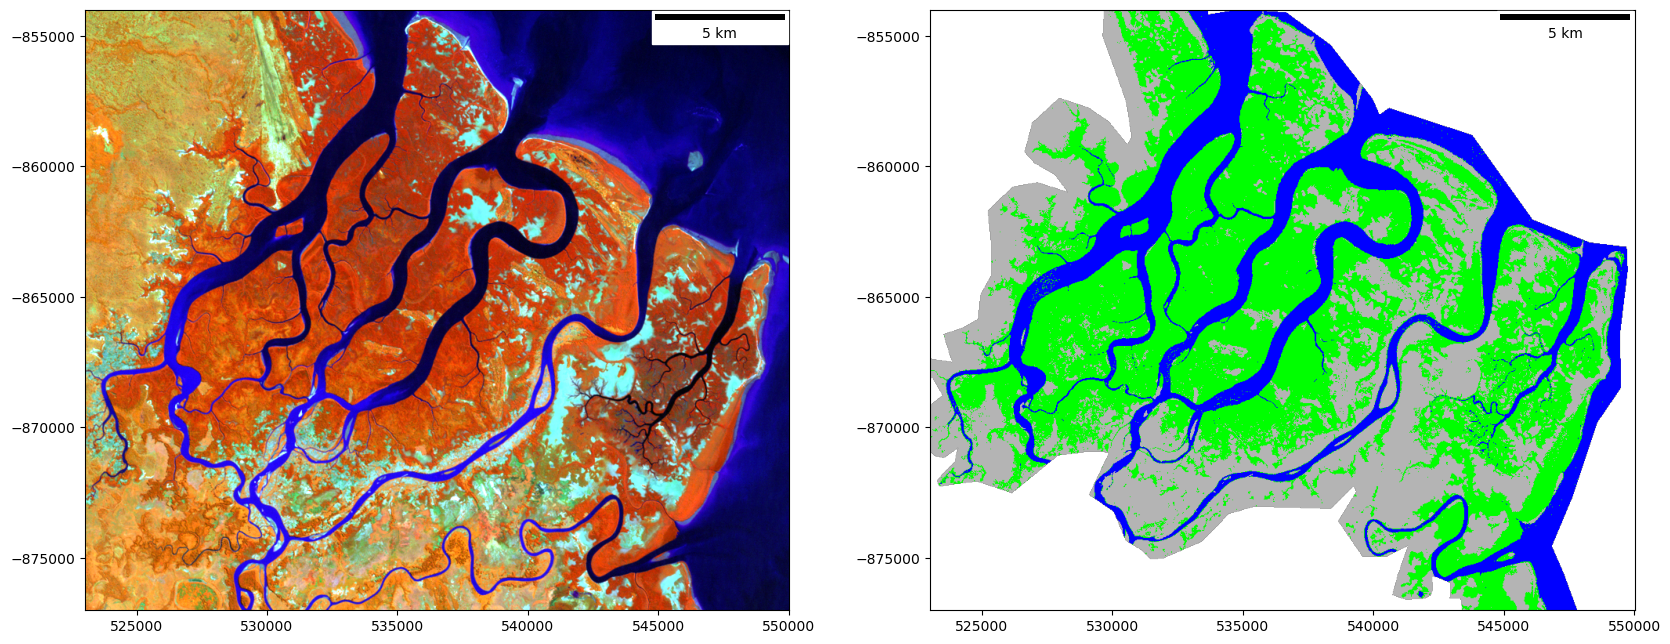

In [16]:
sub_bbox = [523000, 550000, -877000, -854000]

# Create the matplotlib figure
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 20))

# Plot the input image
rsgislib.tools.mapping.create_raster_img_map(
    ax1,
    input_img,
    img_bands=[4, 5, 3],
    img_stch=rsgislib.IMG_STRECTH_CUMULATIVE,
    bbox=sub_bbox,
    show_scale_bar=True,
)

# Plot the classification result
rsgislib.tools.mapping.create_thematic_raster_map(ax2, out_cls_img, bbox=sub_bbox)